## **Importing Needed Libraries**

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

## Reading The Data

In [2]:
class FaceMaskDatasetLoader:
    def __init__(self):
        self.files = []

    #Return absolute paths of imgs from folders
        
    def load_files(self, paths):
        
        for path in paths:
            if os.path.exists(path):
                self.files.extend([os.path.join(path, file) for file in os.listdir(path)])
            else:
                print(f"Directory not found: {path}")
        
        return self.files


with_mask_paths = [
    '/kaggle/input/face-mask-dataset/data/with_mask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask'
]

without_mask_paths = [
    '/kaggle/input/face-mask-dataset/data/without_mask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask'
]

loader = FaceMaskDatasetLoader()

# load 'WithMask' files
with_mask_files = loader.load_files(with_mask_paths)
print("With Mask Files (Absolute Paths):", with_mask_files[:3])

# load 'WithoutMask' files
loader = FaceMaskDatasetLoader()  
without_mask_files = loader.load_files(without_mask_paths)
print("\nWithout Mask Files (Absolute Paths):", without_mask_files[:3])


With Mask Files (Absolute Paths): ['/kaggle/input/face-mask-dataset/data/with_mask/with_mask_3326.jpg', '/kaggle/input/face-mask-dataset/data/with_mask/with_mask_3139.jpg', '/kaggle/input/face-mask-dataset/data/with_mask/with_mask_696.jpg']

Without Mask Files (Absolute Paths): ['/kaggle/input/face-mask-dataset/data/without_mask/without_mask_3248.jpg', '/kaggle/input/face-mask-dataset/data/without_mask/without_mask_2803.jpg', '/kaggle/input/face-mask-dataset/data/without_mask/without_mask_650.jpg']


In [3]:
# data shape
print('with mask images:', len(with_mask_files))
print('without mask images:', len(without_mask_files))

with mask images: 9608
without mask images: 9737


## Data Preprocessing

In [47]:
class DataProcessor:
    def __init__(self, image_size=(128, 128)):
        """
        Initialize the DataProcessor.
        :param image_size: Target size to resize images (default: (128, 128)).
        """
        self.image_size = image_size

    def process_images(self, with_mask_files, without_mask_files):
        """
        Load images from file paths then: 
        label them, 
        normalize, 
        and return data and labels.
        
        return: Tuple of (data, labels) as NumPy arrays.
        """
        data = []
        labels = []

        # Combine files with labels
        all_files = [(file, 1) for file in with_mask_files] + [(file, 0) for file in without_mask_files]

        for file_path, label in all_files:
            try:
                image = Image.open(file_path)
                image = image.resize(self.image_size)
                image = image.convert('RGB')  # Ensure 3-channel RGB
                data.append(np.array(image))
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

        # convert to NumPy arrays
        data = np.array(data)
        labels = np.array(labels)

        # normalize the data
        data = data / 255.0

        return data, labels


processor = DataProcessor()

# Process the images
data, labels = processor.process_images(with_mask_files, without_mask_files)

# Check the results
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Sample labels:", labels[:5])

Data shape: (19345, 128, 128, 3)
Labels shape: (19345,)
Sample labels: [1 1 1 1 1]


In [9]:
print(data[0].shape)

(128, 128, 3)


## Shuffle and split data to train - test

In [19]:

X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, test_size=0.2, shuffle=True, random_state=11
)


In [12]:
print(X_train.shape, X_test.shape)

(15476, 128, 128, 3) (3869, 128, 128, 3)


## **Building a Convolutional Neural Networks (CNN)**

In [13]:
import tensorflow as tf
from tensorflow import keras

In [33]:
num_of_classes = 2
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))


In [34]:
# compile the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [35]:
# training the neural network
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - acc: 0.8041 - loss: 0.4042 - val_acc: 0.9322 - val_loss: 0.1716
Epoch 2/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.9267 - loss: 0.1997 - val_acc: 0.9470 - val_loss: 0.1395
Epoch 3/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.9363 - loss: 0.1649 - val_acc: 0.9496 - val_loss: 0.1404
Epoch 4/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.9508 - loss: 0.1269 - val_acc: 0.9567 - val_loss: 0.1091
Epoch 5/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.9552 - loss: 0.1219 - val_acc: 0.9444 - val_loss: 0.1357


**Model Evaluation**

In [36]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy =', accuracy)

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9496 - loss: 0.1196
Test Accuracy = 0.9426208138465881


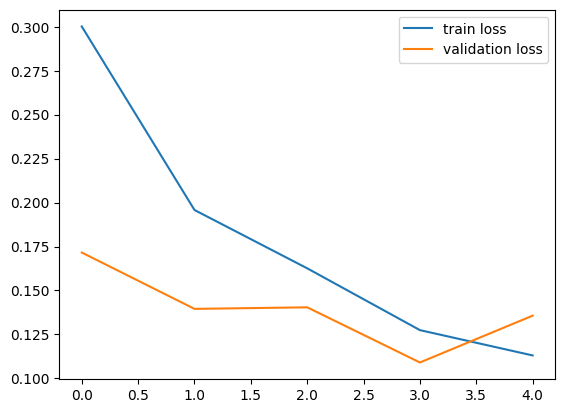

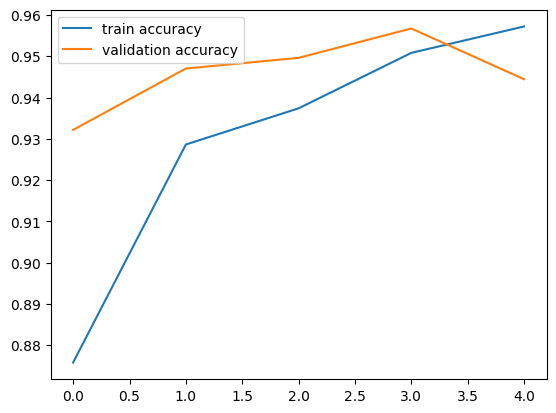

In [37]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1959
           1       0.90      0.99      0.94      1910

    accuracy                           0.94      3869
   macro avg       0.95      0.94      0.94      3869
weighted avg       0.95      0.94      0.94      3869



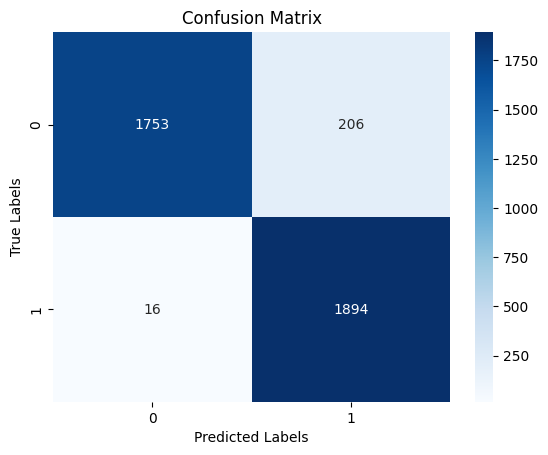

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test = y_test.flatten()  # Flatten y_test for comparison

# Generate classification report
report = classification_report(Y_test, y_pred, target_names=[str(i) for i in range(2)])
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Saving the model**

In [38]:
model.save('model.h5')

## model architecture

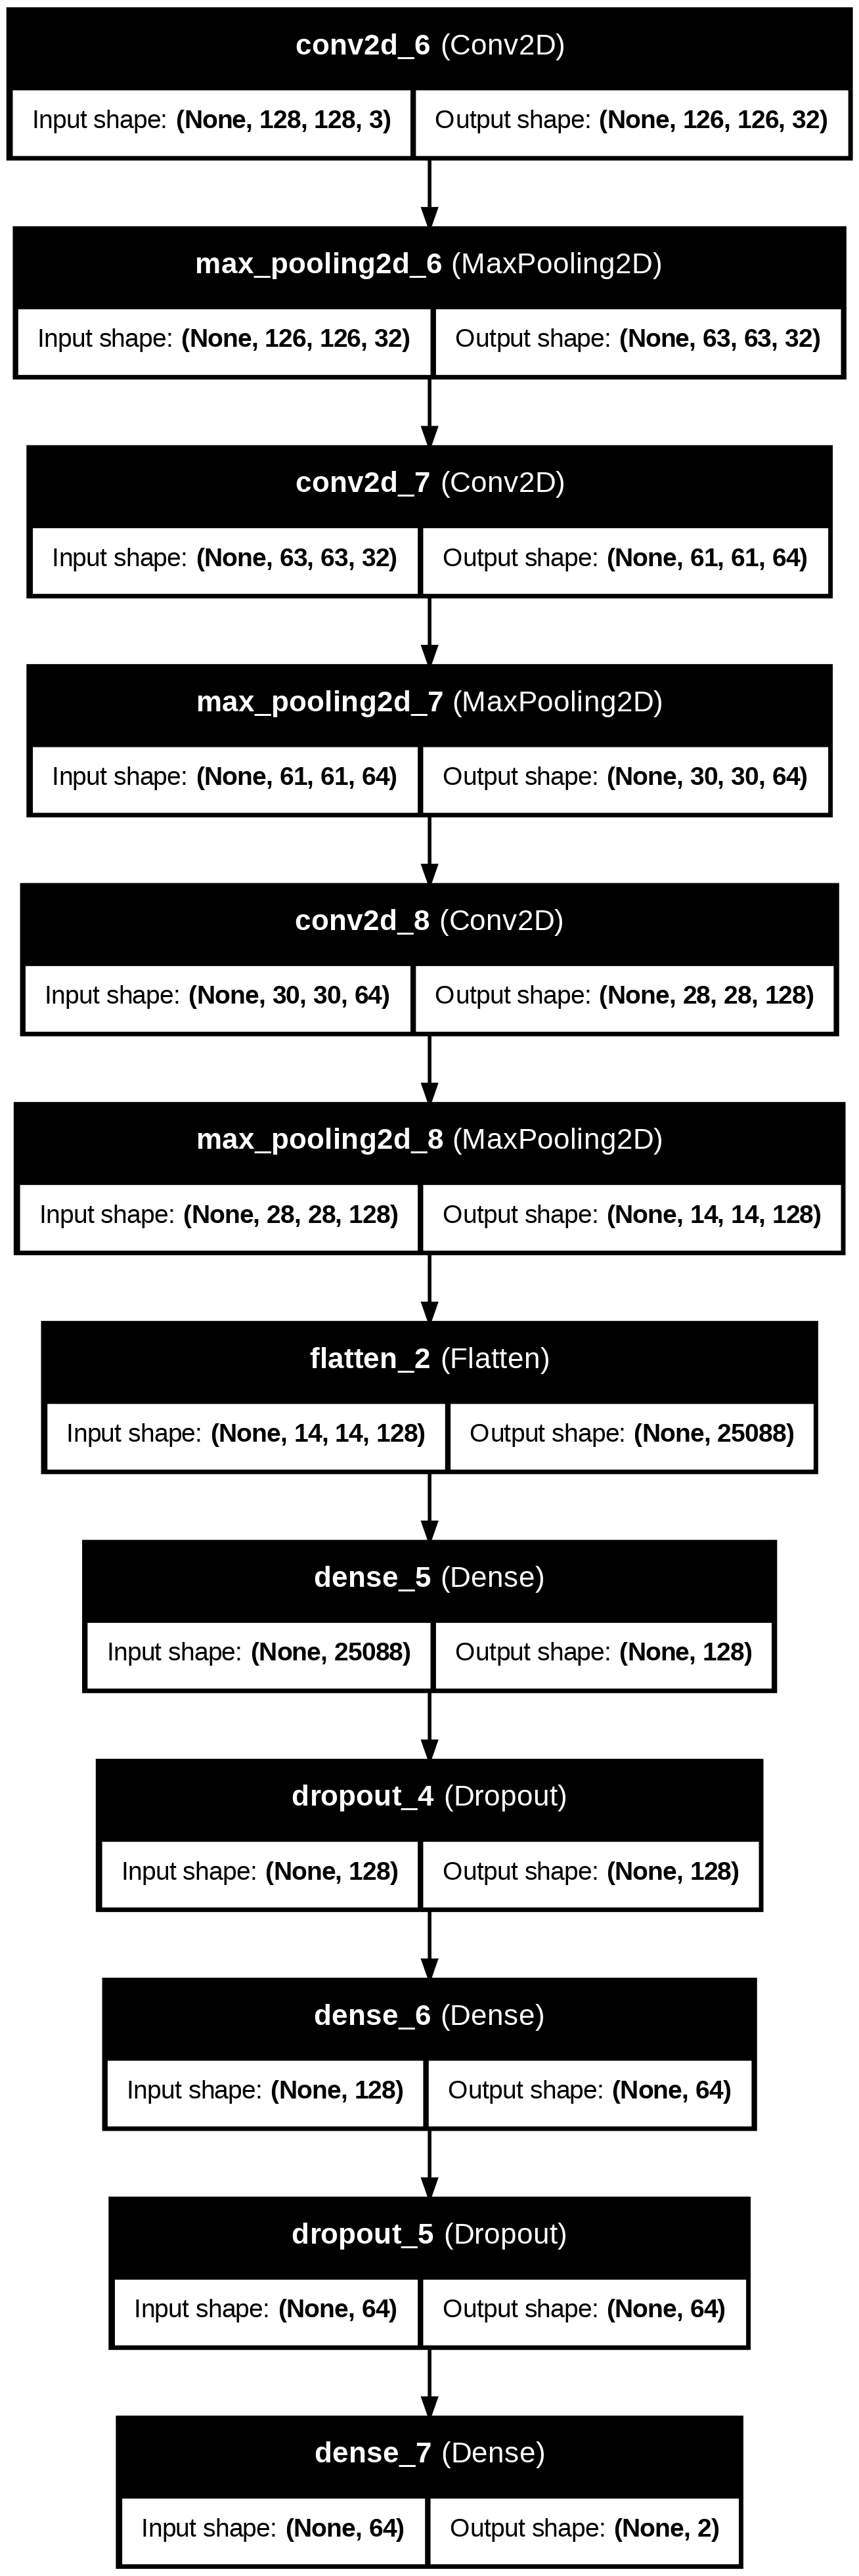

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


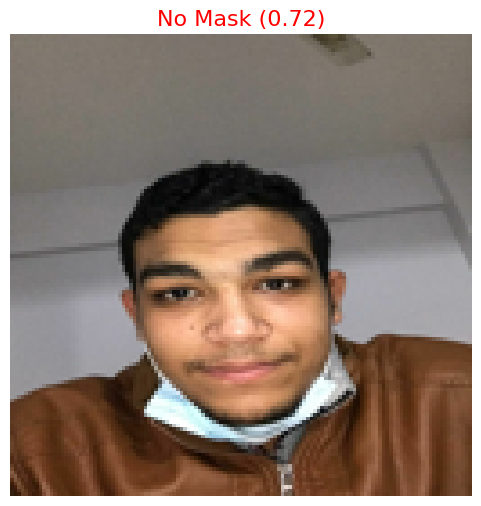

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


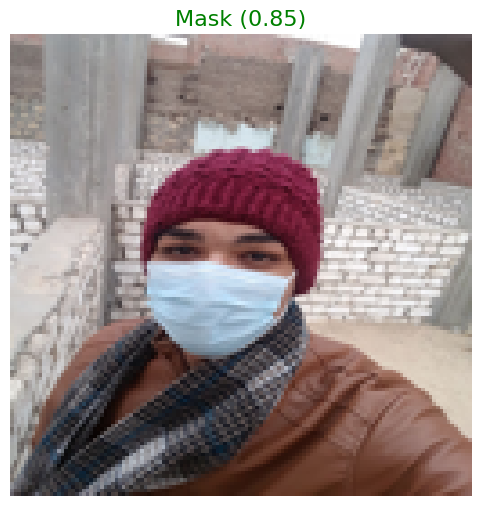

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


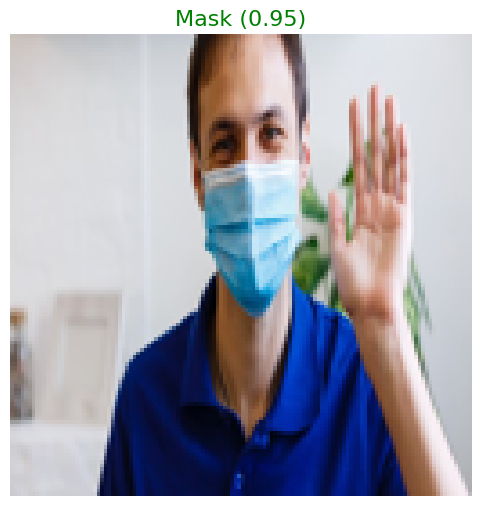

In [39]:
class ImageClassifier:
    def __init__(self, model_path, image_size=(128, 128)):
        """
        Initialize the ImageClassifier.
        :param model_path: Path to the trained model file.
        :param image_size: Target size to resize input images (default: (128, 128)).
        """
        self.image_size = image_size
        self.model = tf.keras.models.load_model(model_path)  # Load the model

    def preprocess_image(self, image_path):
        """
        Preprocess the input image.
        :param image_path: Path to the input image.
        """
        try:
            image = Image.open(image_path)
            image = image.resize(self.image_size)
            image = image.convert('RGB')  
            image_array = np.array(image) / 255.0  
            return image, np.expand_dims(image_array, axis=0)  # Return original image and preprocessed image
        except Exception as e:
            raise ValueError(f"Error processing image {image_path}: {e}")

    def classify(self, image_path):
        """
        Classify the input image.
        :param image_path: Path to the input image.
        :return: Original image, predicted label, and confidence score.
        """
        original_image, preprocessed_image = self.preprocess_image(image_path)
        predictions = self.model.predict(preprocessed_image)
        predicted_label = np.argmax(predictions)
        confidence = predictions[0][predicted_label]
        return original_image, predicted_label, confidence

    def plot_prediction(self, image_path):
        """
        Plot the input image with the prediction result.
        :param image_path: Path to the input image.
        """
        original_image, predicted_label, confidence = self.classify(image_path)

        # Map predicted label to a class description
        label_map = {0: "No Mask", 1: "Mask"}
        prediction_text = f"{label_map[predicted_label]} ({confidence:.2f})"

        # Plot the image with the prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(prediction_text, fontsize=16, color='green' if predicted_label == 1 else 'red')
        plt.show()

# Example usage
model_path = "/kaggle/working/model.h5"
classifier = ImageClassifier(model_path)

# Classify an image and plot the result
image_path = "/kaggle/input/testing11/test-1.jpg"
classifier.plot_prediction(image_path)

image_path = "/kaggle/input/testing11/test-2.jpg"
classifier.plot_prediction(image_path)

image_path = "/kaggle/input/testing11/test-3.jpg"
classifier.plot_prediction(image_path)
